# LFP Prediction
This project shows the feasibility of using time series analysis techniques to make predictions about future values of the signal. Contributers: Ben Latimer, Ziao Chen, Tyler Banks, Drew Headley, and Satish Nair.

## 1) Load and Explore the Data

In [2]:
import pandas as pd
import csv
import pdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
from sklearn.metrics import mean_squared_error
from numpy.random import seed
from tensorflow import set_random_seed
seed(1877)
set_random_seed(2765)

Using TensorFlow backend.


Our /data folder contains all of the data. Each file has several lines of very long rows. It would take a long time to load ALL of the data, so I just load one or a few lines in the cell below. It will still take some time to load this one line.

In [3]:
num_lines = 28
skip_rows = 0
dataset = np.empty((num_lines,900000))
f = open('./data/subject3_seg.csv', newline='')
reader = csv.reader(f)

for i in np.arange(0,skip_rows):
    row = next(reader)

for i in np.arange(0,num_lines):
    row = next(reader)  # gets the first line
    arr = np.array(list(map(float, row)))
    dataset[i,0:len(arr)] = arr

Let's take a look at the data.

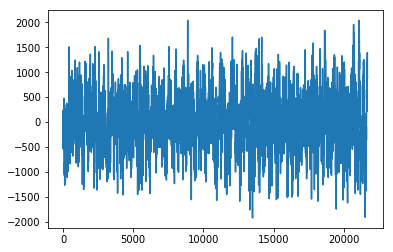

In [4]:
plt.plot(dataset[0,(dataset[0,:]!=0)])

## 2) Artificial Neural Network
We apply a densely connected ANN to the data. Our goal is to train on 100 ms and predict 10 ms. First, we have to break this long row of data into a matrix that can be used for a neural network. I randomly choose num_segs segments that are num_predict+num_lookback milliseconds long. 

In [17]:
num_segs = 1000
num_predict = 10
num_lookback = 100
chunk_size = num_predict + num_lookback

if chunk_size*num_segs > dataset[dataset!=0].shape[0]:
    print ('num_segs too large. only {} chunks possible'.format(int(dataset[dataset!=0].shape[0]/chunk_size)))
    
else:
    supervised_dataset = np.zeros((num_segs,num_lookback+num_predict))

    t_start = time.time()
    ds_row = 0 #Start at row zero of dataset and make chunks until it's exhausted
    ind = 0
    for i in np.arange(0,num_segs):
        # if we have arrived at the end of the row, go to the next row
        if (ind+1)*chunk_size > dataset[ds_row,dataset[ds_row,:]!=0].shape[0]:
            ds_row = ds_row + 1
            ind = 0
        # save it to the supervised dataset
        supervised_dataset[i,:] = dataset[ds_row,0+ind*chunk_size:(ind+1)*chunk_size]
        ind = ind + 1
        
    print("dataset took ", time.time() - t_start, "seconds to generate")
    print(supervised_dataset.shape)


dataset took  3.9641849994659424 seconds to generate
(1000, 110)
[[  -19.    92.    58.   114.   223.   231.   110.     7.    14.   -28.
   -143.  -266.  -393.  -451.  -476.  -540.  -467.  -269.   -94.    -5.
     79.   170.   148.   -18.  -179.  -159.  -162.  -233.  -302.  -437.
   -427.  -401.  -461.  -513.  -392.  -312.  -360.  -368.  -287.  -211.
   -207.  -214.  -128.  -145.  -199.  -108.    -7.    63.    56.    80.
    156.   260.   272.   222.   191.   147.    89.   178.   279.   284.
    319.   411.   309.   154.   186.   203.   154.    59.   121.   168.
     59.   107.   225.   450.   477.   422.   248.   250.    84.  -123.
   -109.   -35.  -308.  -366.   -75.   -41.   -44.   154.   213.   -70.
   -211.  -200.  -241.  -243.  -360.  -449.  -374.  -383.  -393.  -193.
   -331.  -467.  -713.  -888.  -993. -1047. -1080. -1031.  -956.  -895.]
 [ -880.  -872. -1048. -1062.  -806.  -851. -1065. -1180. -1267. -1268.
  -1129. -1042. -1034. -1049.  -998.  -875.  -742.  -709.  -702.  -700

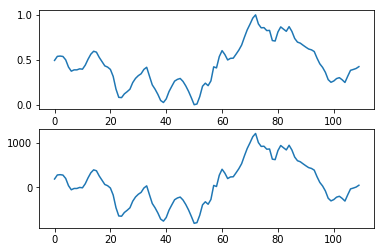

In [18]:
# Scaled supervised dataset
scl_sup_ds = np.zeros((num_segs,num_lookback+num_predict))
sclr = []

def scalewindow(short_seg):
    short_seg = short_seg.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(short_seg)
    scaled = scaled.reshape(len(short_seg),)
    return scaled, scaler

for i in np.arange(0,supervised_dataset.shape[0]):
    scl_sup_ds[i,:], scl = scalewindow(supervised_dataset[i,:])  
    sclr.append(scl)
    
plt.subplot(2,1,1)
plt.plot(scl_sup_ds[10,:])
plt.subplot(2,1,2)
plt.plot(supervised_dataset[10,:])

The following graph shows the training in blue and the part we want to predict in red. This is only one of the num_segs chunks.

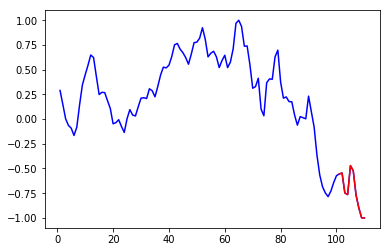

In [13]:
plt.plot(np.linspace(1,num_predict+num_lookback,num=num_predict+num_lookback),scl_sup_ds[10,:],color='blue')
plt.plot(np.linspace(num_lookback+1,num_predict+num_lookback,num=num_predict),scl_sup_ds[10,-num_predict:],color='red')

Now we need to break the supervised learning matrix into training and testing, input (X) and output (Y).

In [14]:
N_train = int(0.8*num_segs)

X_train = scl_sup_ds[0:N_train,0:-num_predict]
Y_train = scl_sup_ds[0:N_train,-num_predict:]
X_test = scl_sup_ds[N_train:,0:-num_predict]
Y_test = scl_sup_ds[N_train:,-num_predict:]

print(X_train.shape)

(800, 100)


Build and fit the neural network!

In [15]:
nnode = 500;
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(nnode, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(int(nnode/2), kernel_initializer='normal', activation='relu'))
	model.add(Dense(int(nnode/4), kernel_initializer='normal', activation='relu'))
	model.add(Dense(Y_train.shape[1], kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
	return model

model took  126.2098479270935 seconds to fit


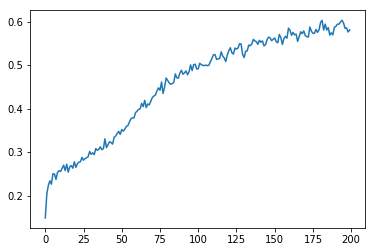

In [139]:
model = baseline_model()
t_start = time.time()
history = model.fit(X_train,Y_train, epochs=200,verbose=0)
print("model took ", time.time()-t_start, "seconds to fit")
plt.plot(history.history['acc'])

In [140]:
y_pred_test = model.predict(X_test)

def unscale(X, Y, S):
    for i in range(X.shape[0]):
        seg = X[i,:]
        seg = seg.reshape(-1,1)
        us_X = S[i].inverse_transform(seg)
        us_X1d = us_X.reshape(us_X.shape[0],)
    
        Y[i,:] = us_X1d
    return Y

y_pred_test_us = np.zeros((y_pred_test.shape[0],y_pred_test.shape[1]))
y_pred_test_us = unscale(y_pred_test, y_pred_test_us, sclr[N_train:])

Y_test_us = np.zeros((Y_test.shape[0],Y_test.shape[1]))
Y_test_us = unscale(Y_test, Y_test_us, sclr[N_train:])

rmse_ann_test = np.sqrt(np.mean((y_pred_test_us-Y_test_us)**2,axis=0))
print("rmse for testing: ", rmse_ann_test)

rmse for testing:  [126.62395855 212.05707906 290.46748199 346.93032968 390.79812826
 428.45457232 458.87652643 488.77066306 515.1408884  538.215453  ]


It would be nice to know what this rmse means. Is it good or bad? Let's compare it to a bad prediction - called the persistence forecast. This is when we just forecast the future samples as the same as the last sample of the input data.

rmse for (persistence) testing:  [528.27925029 548.22462986 573.37077858 606.07641265 639.65230553
 668.99272507 694.96483934 718.47688255 733.03680798 738.60082835]


<BarContainer object of 10 artists>

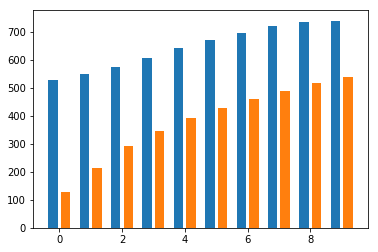

In [141]:
y_pers_train = np.transpose(np.tile(X_train[:,-1], (num_predict,1)))
y_pers_test = np.transpose(np.tile(X_test[:,-1], (num_predict,1)))

y_pers_test_us = np.zeros((y_pers_test.shape[0],y_pers_test.shape[1]))
y_pers_test_us = unscale(y_pers_test, y_pers_test_us, sclr)

rmse_pers_test = np.sqrt(np.mean((y_pers_test_us-Y_test_us)**2,axis=0))
print("rmse for (persistence) testing: ", rmse_pers_test)

plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3)
plt.bar(np.arange(0,num_predict)+0.2,rmse_ann_test,0.3)

Let's see how the neural network did by comparison.

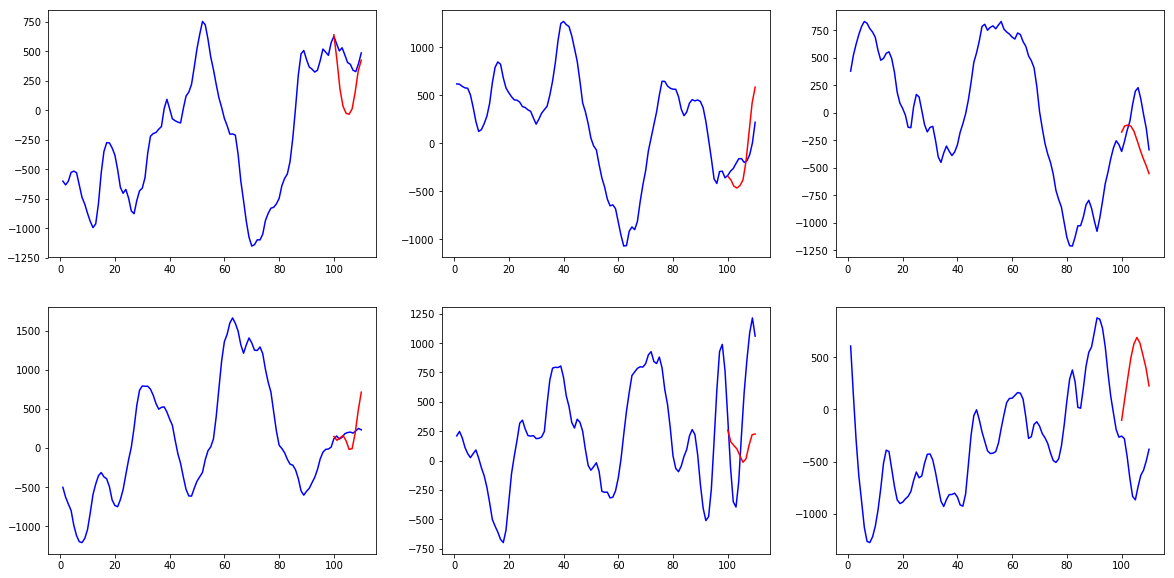

In [142]:
#look at a random sample to see how we did
sample = np.random.randint(N_train,num_segs)
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),supervised_dataset[sample+i,0:chunk_size],color='blue')
    plt.plot(np.linspace(num_lookback,chunk_size,num=num_predict),y_pred_test_us[sample+i-N_train,:],color='red')

In [114]:
# Let's see if scaling the data between -1 and 1 is better.
scaled_dataset = np.zeros((num_segs,chunk_size))

for i in np.arange(0,num_segs):
    scaled_dataset[i,:] = (supervised_dataset[i,:])/(np.max(supervised_dataset[i,:])-np.min(supervised_dataset[i,:]))

N_train = int(0.8*num_segs)

X_train_scl = scaled_dataset[0:N_train,0:-num_predict]
Y_train_scl = scaled_dataset[0:N_train,-num_predict:]
X_test_scl = scaled_dataset[N_train:,0:-num_predict]
Y_test_scl = scaled_dataset[N_train:,-num_predict:]

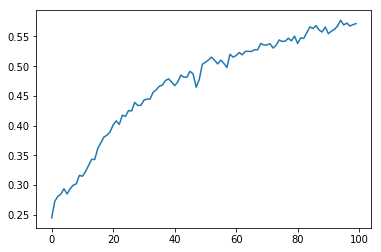

In [115]:
model = baseline_model()
history = model.fit(X_train_scl,Y_train_scl, epochs=100,verbose=0)
#plt.plot(history.history['loss']) # Visualize convergence
plt.plot(history.history['acc'])

In [116]:
y_pred_train = model.predict(X_train_scl)
y_pred_test = model.predict(X_test_scl)

rmse = np.sqrt(np.mean((y_pred_train-Y_train_scl)**2,axis=1))
print("rmse for training: ", np.mean(rmse))

rmse = np.sqrt(np.mean((y_pred_test-Y_test_scl)**2,axis=1))
print("rmse for testing: ", np.mean(rmse))

rmse for training:  0.04524701218435759
rmse for testing:  0.15540951528607225


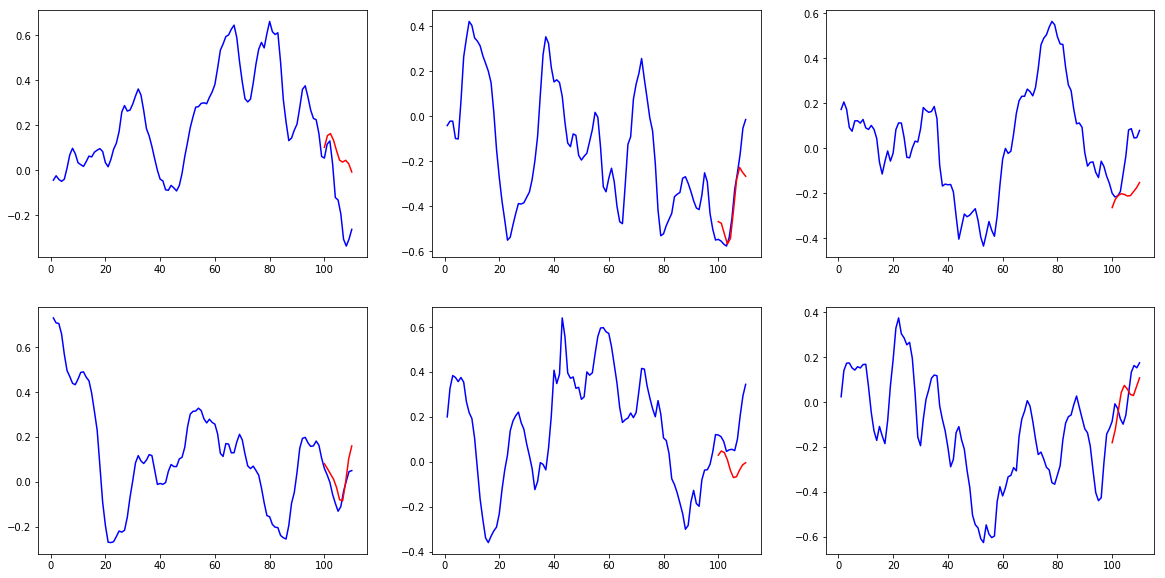

In [126]:
#look at a random sample to see how we did
sample = np.random.randint(N_train,num_segs)

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scaled_dataset[sample+i,0:chunk_size],color='blue')
    plt.plot(np.linspace(num_lookback,chunk_size,num=num_predict),y_pred_test[sample+i-N_train,:],color='red')

## 3) Recurrent Neural Network *!!BETA VERSION, NOT YET IMPLEMENTED!!*
We use a Long Short Term Memory (LSTM) network to make predictions.
Resources:
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
from sklearn.metrics import mean_squared_error

In [149]:
df = pd.read_csv('./data/subject6_seg.csv',header=None,na_filter=False,skiprows=50) # Choose any subject
dataset = df.values[0]
print(dataset.shape)

(62021,)


We will divide the time series into training and testing segments

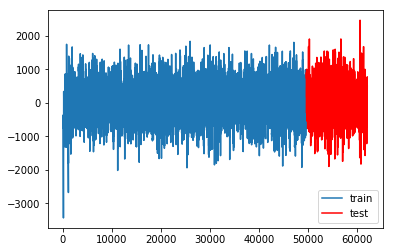

In [150]:
num_train = int(0.8*len(dataset))
num_test = len(dataset) - num_train

t = np.arange(0,len(dataset))

ds_train = dataset[0:num_train]
ds_test = dataset[num_train:num_train+num_test]

plt.plot(t[0:len(ds_train)],ds_train,label='train')
plt.plot(t[len(ds_train):],ds_test,'r',label='test')
plt.legend()

The data for an LSTM needs to be scaled between -1 and 1. Here we define and test a function to do this.

C:\Users\latimerb\Anaconda3\envs\keras_tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


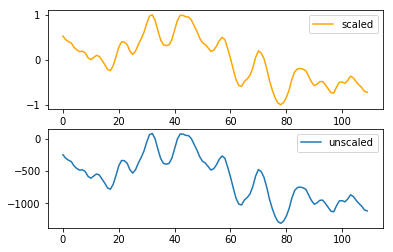

In [151]:
ss = dataset[200:310]

def scalewindow(short_seg):
    short_seg = short_seg.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled = scaler.fit_transform(short_seg)
    scaled = scaled.reshape(len(short_seg),)
    return scaled, scaler

ss_scaled, ss_scaler = scalewindow(ss)
plt.subplot(2,1,1)
plt.plot(ss_scaled,color='orange',label='scaled')
plt.legend()
plt.subplot(2,1,2)
plt.plot(ss,label='unscaled')
plt.legend()

This is the critical step in preparing the data for an LSTM. Each row in the training data matrix will be a "window" with one output. We will slide this window along the training and testing datasets to generate the matrix.

In [152]:
window_size = 100
prediction = 10

# This function accepts a one dimensional array, in_size (number of past time samples), and out_size (number of future)
def series_to_supervised(ds,in_size,out_size):
    # initialize the supervised learning matrix
    supervised = np.zeros((len(ds)-(in_size+out_size)+1,in_size+out_size))
    scalers = []
    # for each row, get the data from ds
    for i in range(1,len(ds)-(in_size+out_size)+2):
        seg = ds[i-1:(in_size-1)+i+out_size]
        supervised[i-1,0:in_size+out_size], scl = scalewindow(seg)
        scalers.append(scl)
    return supervised, scalers


train_sup, train_scl = series_to_supervised(ds_train,window_size,prediction)
test_sup, test_scl = series_to_supervised(ds_test,window_size,prediction)

C:\Users\latimerb\Anaconda3\envs\keras_tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Now we will define the model.

In [159]:
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:-n_lag], train[:, -n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

model_lstm = fit_lstm(train_sup, prediction, 1, 2, 10)
model_lstm.summary()

Epoch 1/1
49507/49507 [==============================] - 132s - loss: 0.1720   
Epoch 1/1
49507/49507 [==============================] - 127s - loss: 0.1529   
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (1, 10)                   4440      
_________________________________________________________________
dense_12 (Dense)             (1, 10)                   110       
Total params: 4,550.0
Trainable params: 4,550
Non-trainable params: 0.0
_________________________________________________________________


In [163]:
# Make one forecast
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast

def make_forecasts(model, n_batch, test, n_lag):
    forecasts = np.zeros((test.shape[0],n_lag))
    for i in range(test.shape[0]):
        X, y = test[i, 0:-n_lag], test[i, -n_lag:]
        # make forecast
        forecasts[i,:] = forecast_lstm(model, X, n_batch)
    return forecasts

scaled_forecasts = make_forecasts(model_lstm, 1, test_sup, prediction)

In [164]:
# inverted forecasts
iv_forecasts = np.zeros((unscaled_forecasts.shape[0], unscaled_forecasts.shape[1]))
iv_test_sup = np.zeros((test_sup.shape[0],test_sup.shape[1]))

def unscale(X, Y, S):
    for i in range(X.shape[0]):
        seg = X[i,:]
        seg = seg.reshape(-1,1)
        us_X = S[i].inverse_transform(seg)
        us_X1d = us_X.reshape(us_X.shape[0],)
    
        Y[i,:] = us_X1d
    return Y

unscaled_forecasts = unscale(scaled_forecasts, iv_forecasts, test_scl)
unscaled_test_sup = unscale(test_sup, iv_test_sup, test_scl)

In [173]:
Y_test = unscaled_test_sup[:,-10:]

rmse = np.sqrt(np.mean((unscaled_forecasts-Y_test)**2,axis=0))
print("rmse for (LSTM) testing: ", rmse)

rmse for (LSTM) testing:  [143.06246733 210.32594018 274.22394367 327.03394451 371.17796943
 406.1773316  432.29888691 451.45409809 466.10440712 478.82614548]


12296


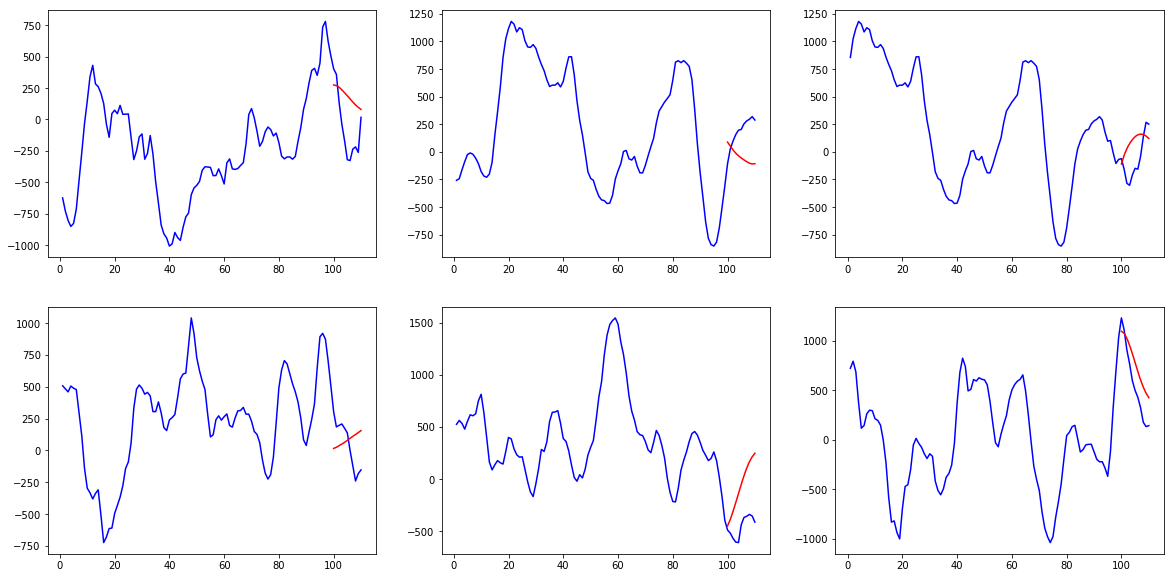

In [158]:
#look at a random sample to see how we did
print(unscaled_test_sup.shape[0])

num_lookback = 100
num_predict = 10
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,unscaled_test_sup.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),unscaled_test_sup[sample,0:chunk_size],color='blue')
    plt.plot(np.linspace(num_lookback,chunk_size,num=num_predict),unscaled_forecasts[sample,:],color='red')